# Storing ApRES data from Greenland in an xarray dataset
This notebook demonstrates a way of putting ApRES data into an xarray in a useful format. 

It also shows demonstrates a few ways of stacking and plotting the data once it is in xarray. 

## Load packages and add ApRES scripts to path

In [1]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/phase-sensitive-radar-processing/code/ApRES_Python_Nicholls_2021")

In [2]:
import ApRESDefs
#import importlib
#importlib.reload(ApRESDefs) 
import ApRES_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

## Load a single burst

In [3]:
d1 = "DATA2022-05-26-1536.DAT"
d2 = "DATA2022-09-22-2220.DAT"

In [4]:
folder = "/Users/jkingslake/Documents/data/ApRES_greenland/two_examples/"

In [5]:
dat = ApRESDefs.DataFileObject(folder + d1)

## Define functions which make 1) make 3D array from a burst, 2) extract coordinate info for the burst, and 3) extract the timestamp

The 3D arrays will have the following dimensions:
- chirp_time (len=40001, 0-1 sec), 
- chirp_num (len=20 0:19), 
- attenuator_setting_pair (len=2, [0, 1])



In [6]:
def burst_to_3d_arrays(burst, max_range=2000):
    burst.Header['N_ADC_SAMPLES']
    chirp_3d = np.zeros((burst.Header['N_ADC_SAMPLES'],burst.Header['NSubBursts'],burst.Header['nAttenuators']))
    
    test_profile = burst.ExtractChirp([0]).FormProfile()
    
    profile_3d = np.zeros((len(test_profile.Profile),burst.Header['NSubBursts'],burst.Header['nAttenuators']), dtype=complex)

    setting_counter = 0
    chirp_counter = 0
    for i in np.arange(burst.Header['NChirps']):

        chirp_new = burst.ExtractChirp([i]) 

        profile_new = chirp_new.FormProfile()

        chirp_3d[:,chirp_counter,setting_counter] = chirp_new.vdat
        profile_3d[:,chirp_counter,setting_counter] = profile_new.Profile  

        #print(chirp_counter)

        # keep track of which pair of settings we are using
        setting_counter += 1
        if setting_counter >= burst.Header['nAttenuators']: # if the counter reaches nAttenuators, reset it to zero 
            setting_counter = 0
            chirp_counter += 1

            
    n = np.argmin(profile_new.Range<=max_range)
    cropped_profile_3d = profile_3d[:n,:,:]    
    
    return chirp_3d, cropped_profile_3d

def coords_from_burst(burst, max_range=2000):
    
    chirp = burst.ExtractChirp([0])
    
    profile = chirp.FormProfile()
    n = np.argmin(profile.Range<=max_range)
    cropped_range = profile.Range = profile.Range[:n] 
    return  chirp.t, cropped_range

def timestamp_from_burst(burst):
    return pd.to_datetime(burst.Header["Time stamp"]) 


## Define a function to put data in an xarray

In [7]:
def burst_to_xarray(burst):

    chirps , profiles = burst_to_3d_arrays(burst,1500)
    chirp_time, profile_range = coords_from_burst(burst,1500)
    time = timestamp_from_burst(burst)

    chirps = chirps[None,:,:,:]
    profiles = profiles[None,:,:,:]

    xarray_out = xr.Dataset(
        data_vars=dict(
            chirp=(["time","chirp_time", "chirp_num", "attenuator_setting_pair"], chirps),
            profile=(["time", "profile_range", "chirp_num", "attenuator_setting_pair"], profiles),
        ),
        coords=dict(
            time = [time],
            chirp_time=chirp_time,
            profile_range=profile_range, 
            chirp_num = np.arange(burst.Header['NSubBursts']),
            AFGain=(["attenuator_setting_pair"], burst.Header['AFGain'][0:burst.Header['nAttenuators']]),
            attenuator=(["attenuator_setting_pair"], burst.Header['Attenuator1'][0:burst.Header['nAttenuators']]),
        ),
        attrs=dict(description="One burst in an xarray - chirps and profiles"),
    )
    return xarray_out

## Run this function for every burst in the dat file and concatenate the resulting datasets
The approach is to make a list of containing the arrays and do the concatenation in one step at the end.

In [8]:
datasets = []
for burst_number in tqdm(range(dat.NoBurstsInFile)):
    burst = dat.ExtractBurst(burst_number)
    
    next_xarray = burst_to_xarray(burst)
    
    datasets.append(next_xarray)
    
multi_burst = xr.concat(datasets,dim='time') 

100%|███████████████████████████████████████████| 94/94 [03:26<00:00,  2.20s/it]


This gives us an xarray with all 94 bursts in one xarray. 

In [9]:
multi_burst

<xarray.Dataset>
Dimensions:        (time: 94, chirp_time: 40001, chirp_num: 20,
                    attenuator_setting_pair: 2, profile_range: 7134)
Coordinates:
  * time           (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-05-27T1...
  * chirp_time     (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.5e+03 1.5e+03
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    AFGain         (attenuator_setting_pair) int64 -4 -14
    attenuator     (attenuator_setting_pair) float64 5.0 5.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp          (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile        (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
Attributes:
    description:  One burst in an xarray - chirps and profiles

To do: add attributes with `long_name`s and units for each variable and coordinate.

## Define a function for computing dB from the complex profiles.

In [10]:
def dB(profile_da):
    return 20*np.log10(np.abs(profile_da))


## Examine the data stored in the xarray
First let's see the time period these data cover, both numerically and visually:

Data cover 1394 minutes, or 23 hours.


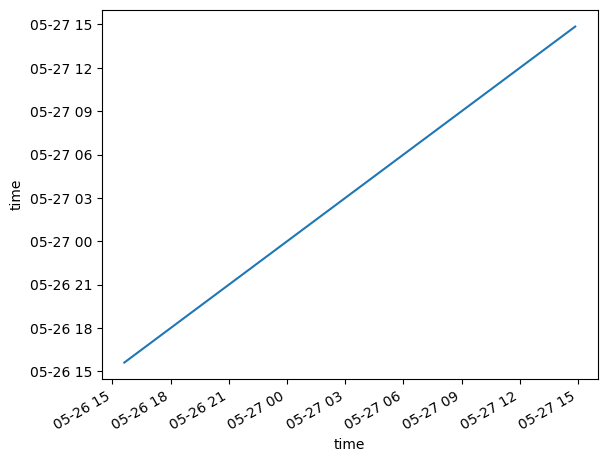

In [11]:
multi_burst.time.plot();
time_spanned_by_data = (multi_burst.time[-1] - multi_burst.time[0]).values
print(f"Data cover {np.timedelta64(time_spanned_by_data,'m')}, or {np.timedelta64(time_spanned_by_data,'h')}.")

# Stack the bursts
Let's use xarray's mean method to stack each burst. The keeps the chirps from different attenuator settings separate. 

In [12]:
%%time
stacked_profiles = multi_burst.profile.mean(dim='chirp_num')

CPU times: user 1.62 s, sys: 318 ms, total: 1.94 s
Wall time: 2.87 s


We can then plot these stacked profiles as a 2D function of time and depth, picking one of the attenuator setting pairs to plot.

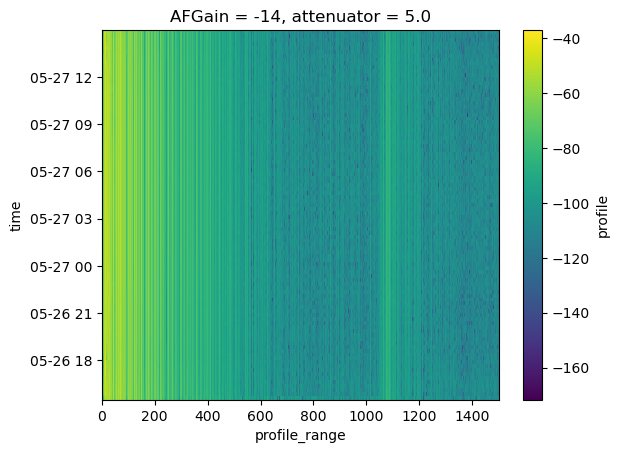

In [13]:
dB(np.abs(stacked_profiles)).isel(attenuator_setting_pair=1).plot();

Next we can plot over all chirps and all bursts. We also plot using hvplot, which provides some interactivity

In [16]:
import hvplot.xarray 
all_stacked = dB(multi_burst.profile.isel(attenuator_setting_pair=0).mean(dim=['time','chirp_num']))
print(f"This stacks {multi_burst.time.size * multi_burst.chirp_num.size} chirps.")
all_stacked.hvplot()


This stacks 1880 chirps.


:Curve   [profile_range]   (profile)

Finally, let's plot each stacked profile separately and use a slider to change between which burst we plot. 

In [17]:
dB(multi_burst.profile.isel(attenuator_setting_pair=0).mean(dim=['chirp_num'])).hvplot.line(ylim=[-140,-20])

:DynamicMap   [time]
   :Curve   [profile_range]   (profile)

...and do the same for the chirps. 

In [18]:
multi_burst.chirp.isel(attenuator_setting_pair=0).mean(dim=['chirp_num']).hvplot.line()

:DynamicMap   [time]
   :Curve   [chirp_time]   (chirp)